# **Setup**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BaseDir = "/content/drive/MyDrive/FYP/data"
Proc = f"{BaseDir}/processed"

Path_Ethnic = f"{Proc}/ethnic_composition_clean.csv"
Path_IMS    = f"{Proc}/ims_stock_table1_bothsex_countries.csv"

# Libraries
!pip -q install country_converter==1.2.0 openpyxl==3.1.5 pyarrow==17.0.0

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.1 MB/s eta 0:00:00


# **EDA for the Ethnic Composition Dataset**

In [16]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, country_converter as coco

pd.set_option("display.max_columns", 100)

In [17]:
ethnic = pd.read_csv(Path_Ethnic, dtype={"iso3":str})
ethnic.columns = [c.strip().lower().replace(" ","_") for c in ethnic.columns]
ethnic["year"]  = pd.to_numeric(ethnic["year"], errors="coerce").astype("Int64")
ethnic["value"] = pd.to_numeric(ethnic["value"], errors="coerce")
ethnic = ethnic.dropna(subset=["iso3","year","ethnic_group","value"])
print("Rows:", len(ethnic), "| Countries:", ethnic['iso3'].nunique(), "| Years:", ethnic['year'].min(), "→", ethnic['year'].max())

Rows: 7897 | Countries: 109 | Years: 1995 → 2023


## 1. How complete is the ethnic composition data by country-year?

In [18]:
def plot_ethnic_coverage(ethnic_df):

    cov = ethnic_df.groupby("iso3", as_index=False)["year"].nunique().sort_values("year", ascending=False)
    plt.figure(figsize=(8,5))
    plt.barh(cov["iso3"].head(25), cov["year"].head(25))
    plt.gca().invert_yaxis()
    plt.title("Number of Available Years per Country (Top 25)")
    plt.xlabel("Unique Years Recorded")
    plt.ylabel("Country ISO3")
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    return cov

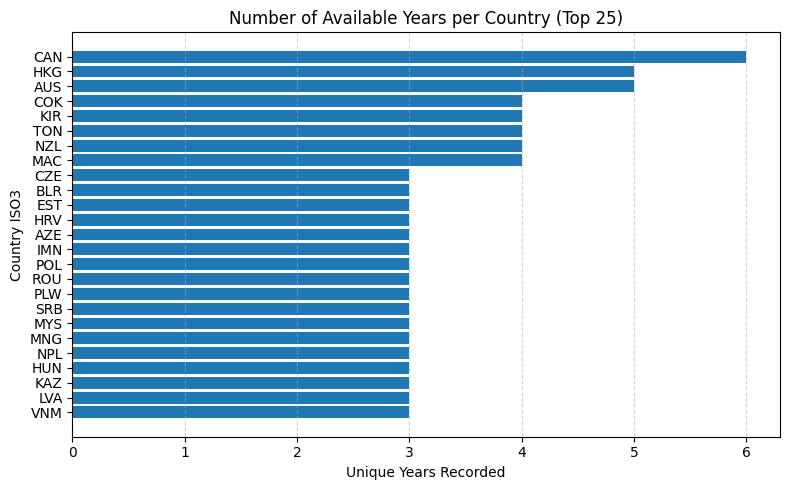

,iso3,year
20,CAN,6
43,HKG,5
8,AUS,5
23,COK,4
54,KIR,4


In [19]:
coverage_table = plot_ethnic_coverage(ethnic)
coverage_table.head()

In [58]:
coverage_table[coverage_table["iso3"].isin(["DEU","USA","MYS"])]

,iso3,year
71,MYS,3
101,USA,3


## 2. Total population vs. sum of ethnic groups

In [20]:
def plot_total_ethnic_sum(ethnic_df, dest_iso3):
    df = (ethnic_df[ethnic_df["iso3"]==dest_iso3]
          .groupby("year", as_index=False)["value"].sum())
    plt.figure(figsize=(8,4))
    plt.plot(df["year"], df["value"]/1e6, marker="o", linewidth=2)
    plt.title(f"Sum of Recorded Ethnic Groups in {dest_iso3}")
    plt.xlabel("Year")
    plt.ylabel("Sum of Ethnic Counts (Millions)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

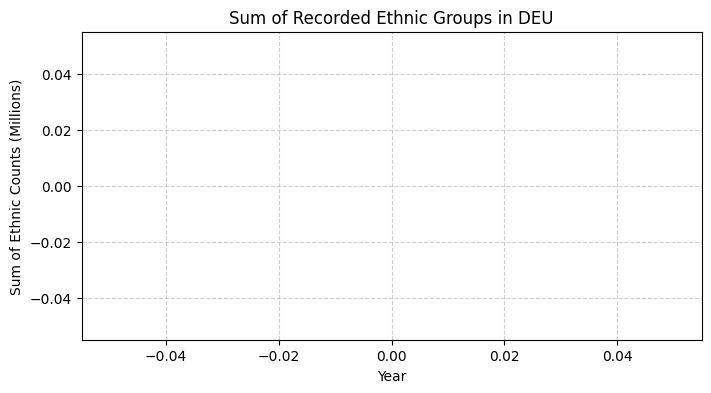

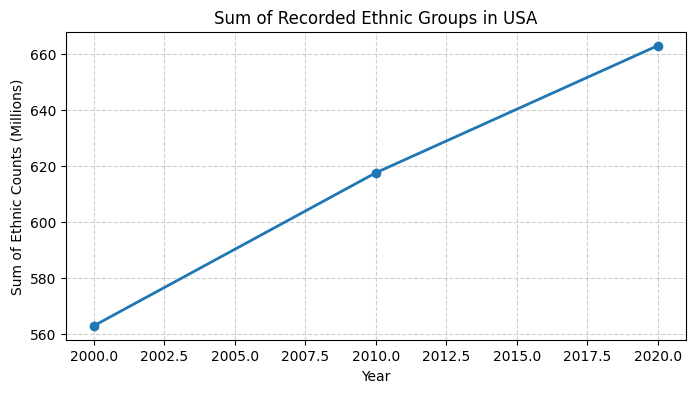

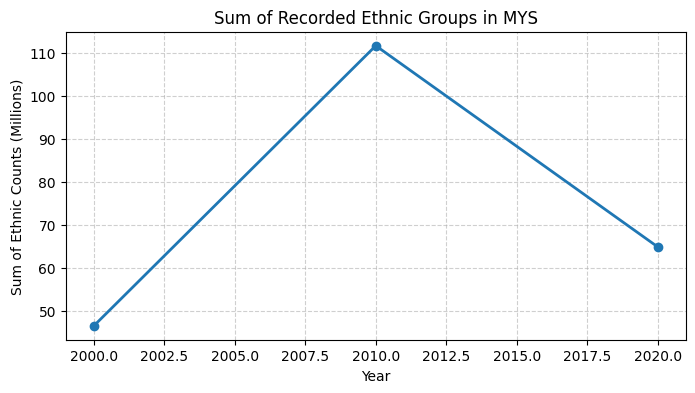

In [21]:
plot_total_ethnic_sum(ethnic, "DEU")
plot_total_ethnic_sum(ethnic, "USA")
plot_total_ethnic_sum(ethnic, "MYS")

## 3. Trend of each major ethnic group in key countries

In [22]:
def plot_major_ethnic_trends(ethnic_df, dest_iso3, top_n=5):

    sub = ethnic_df[ethnic_df["iso3"]==dest_iso3]
    top_groups = (sub.groupby("ethnic_group", as_index=False)["value"].sum()
                    .sort_values("value", ascending=False).head(top_n)["ethnic_group"].tolist())
    sub = sub[sub["ethnic_group"].isin(top_groups)]
    plt.figure(figsize=(9,5))
    for g in top_groups:
        d = sub[sub["ethnic_group"]==g]
        plt.plot(d["year"], d["value"]/1e6, marker="o", label=g)
    plt.title(f"Top {top_n} Ethnic Groups in {dest_iso3}")
    plt.xlabel("Year"); plt.ylabel("Population (Millions)")
    plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
    plt.show()

/tmp/ipython-input-146185371.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.grid(True, linestyle="--", alpha=0.5); plt.legend()


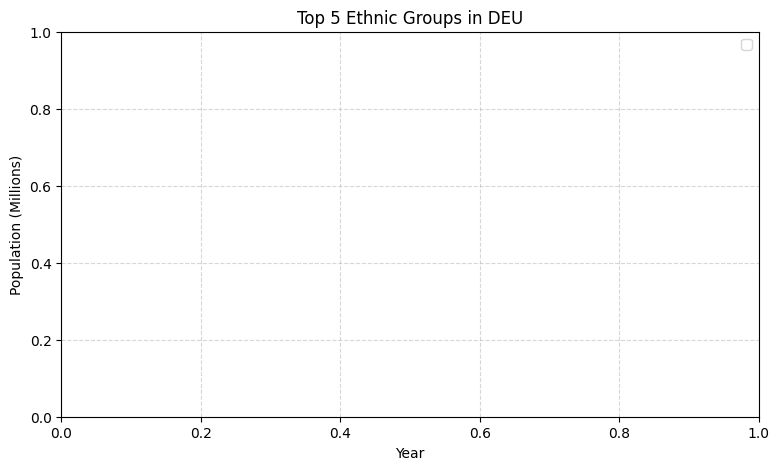

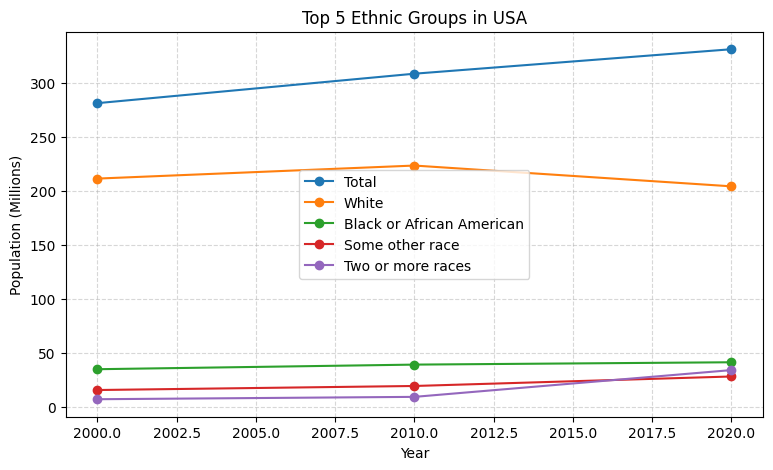

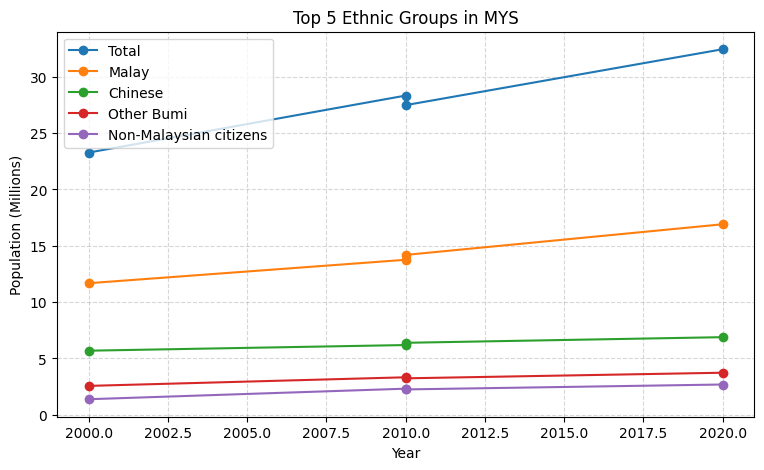

In [23]:
plot_major_ethnic_trends(ethnic, "DEU", top_n=5)
plot_major_ethnic_trends(ethnic, "USA", top_n=5)
plot_major_ethnic_trends(ethnic, "MYS", top_n=5)

## 4. Distribution of ethnic group counts

In [24]:
def plot_ethnic_distribution(ethnic_df, dest_iso3):

    df = ethnic_df[ethnic_df["iso3"]==dest_iso3]
    latest = df[df["year"]==df["year"].max()]
    plt.figure(figsize=(6,4))
    sns.histplot(latest["value"]/1e6, bins=20, kde=True)
    plt.title(f"Distribution of Ethnic Group Counts in {dest_iso3} ({int(latest['year'].max())})")
    plt.xlabel("Population (Millions per Ethnic Group)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

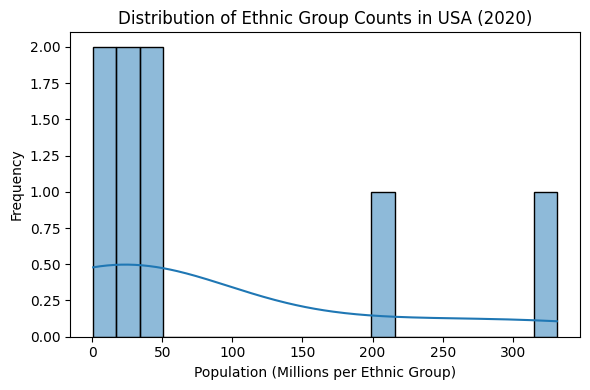

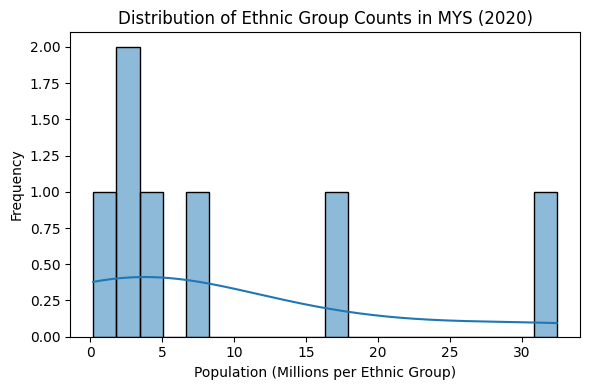

In [26]:
plot_ethnic_distribution(ethnic, "USA")
plot_ethnic_distribution(ethnic, "MYS")

## 5. Outlier or data entry check (year-to-year spikes)

In [27]:
def plot_ethnic_outlier_check(ethnic_df, dest_iso3):

    df = (ethnic_df[ethnic_df["iso3"]==dest_iso3]
          .groupby("year", as_index=False)["value"].sum()
          .sort_values("year"))
    df["diff"] = df["value"].diff()
    plt.figure(figsize=(8,4))
    plt.plot(df["year"], df["diff"]/1e6, marker="o", color="darkred")
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.title(f"Year-to-Year Change in Total Ethnic Counts ({dest_iso3})")
    plt.xlabel("Year"); plt.ylabel("Δ Population (Millions)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    return df[abs(df["diff"]) > df["diff"].std()*3]  # Return suspected outliers

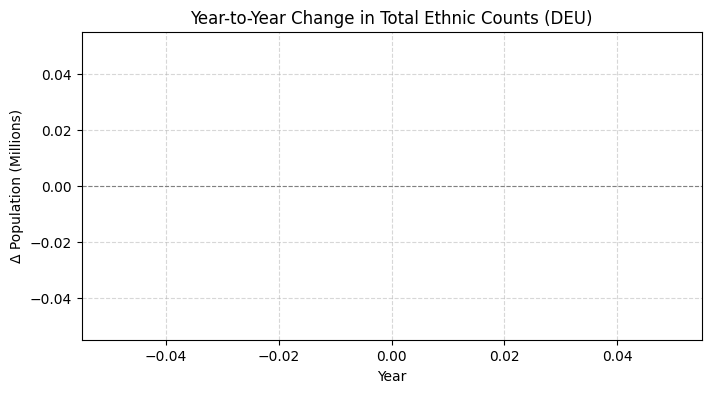

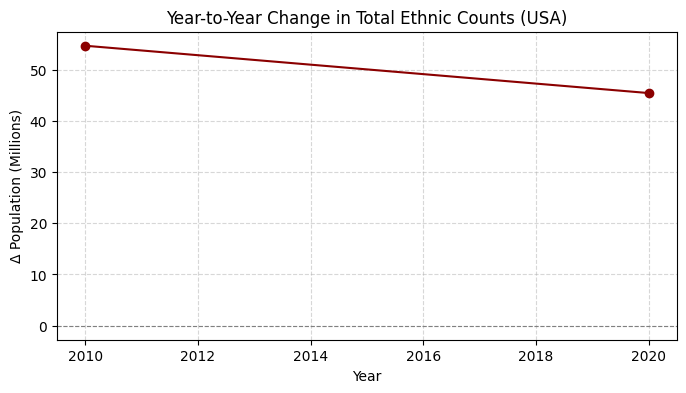

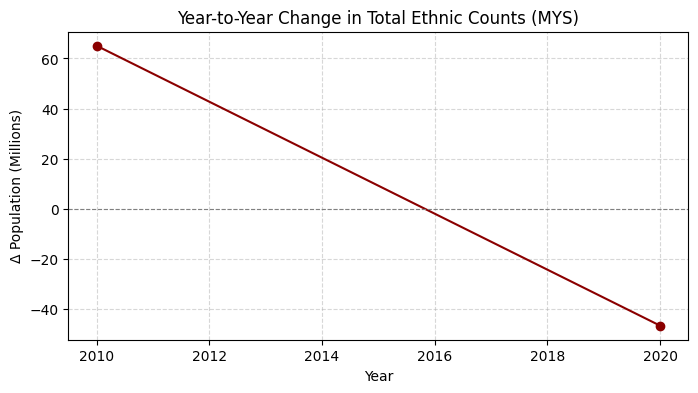

,year,value,diff


In [28]:
plot_ethnic_outlier_check(ethnic, "DEU")
plot_ethnic_outlier_check(ethnic, "USA")
plot_ethnic_outlier_check(ethnic, "MYS")

## Summary


====== USA ======


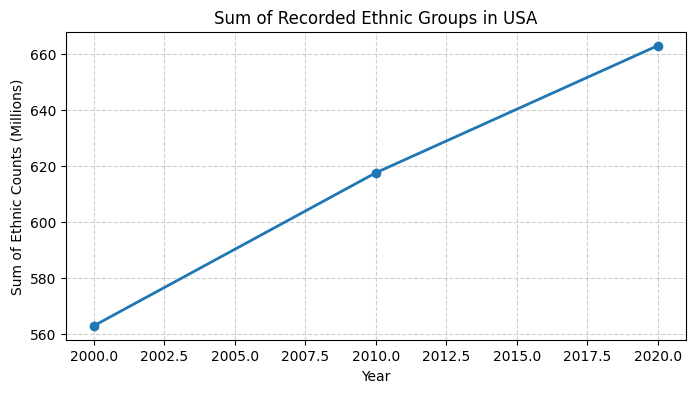

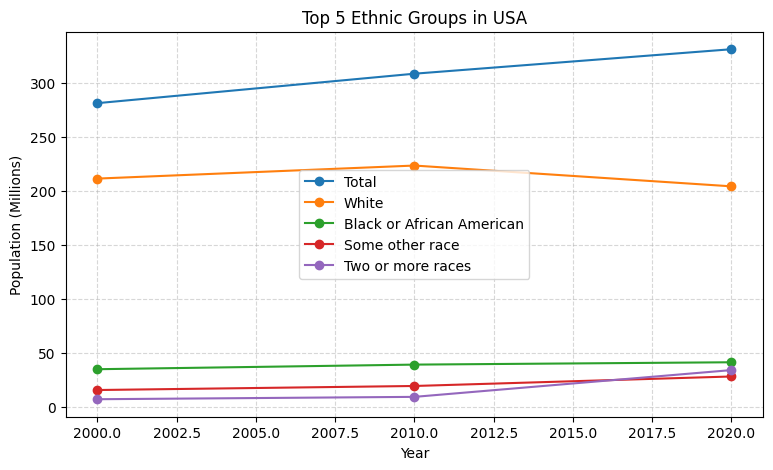

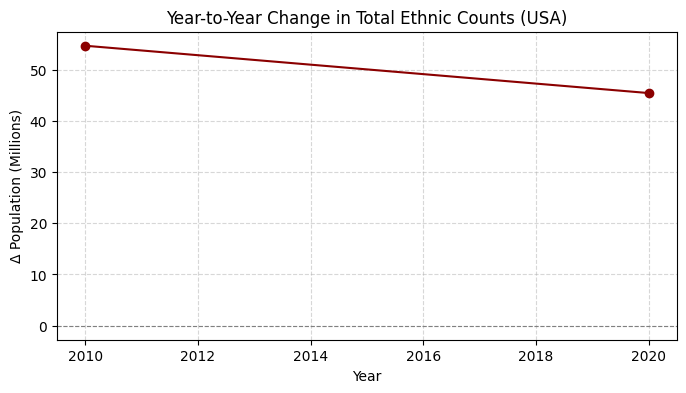


====== DEU ======


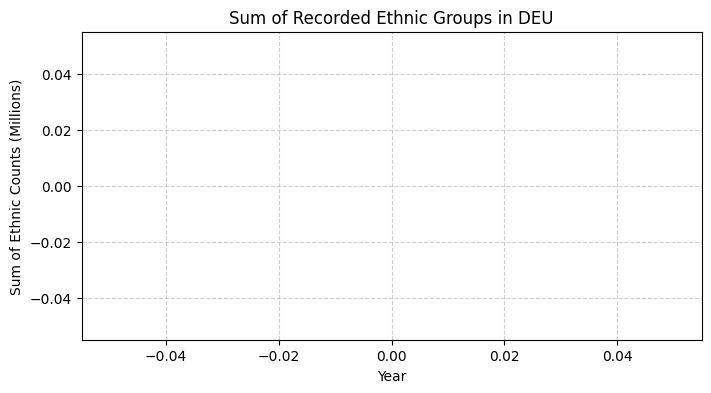

/tmp/ipython-input-146185371.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.grid(True, linestyle="--", alpha=0.5); plt.legend()


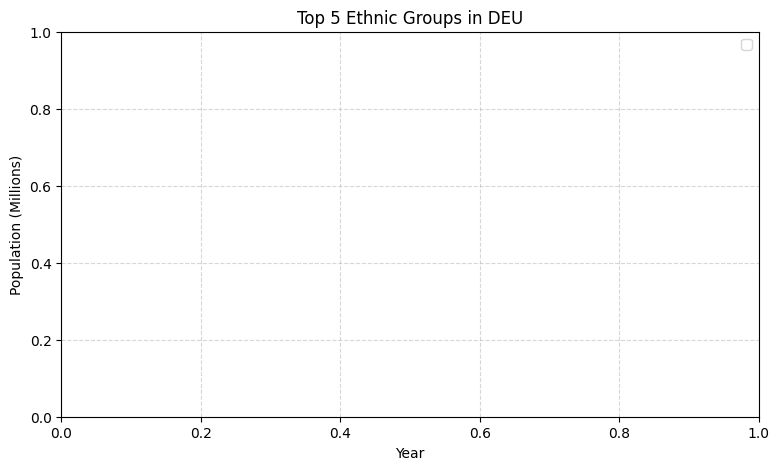

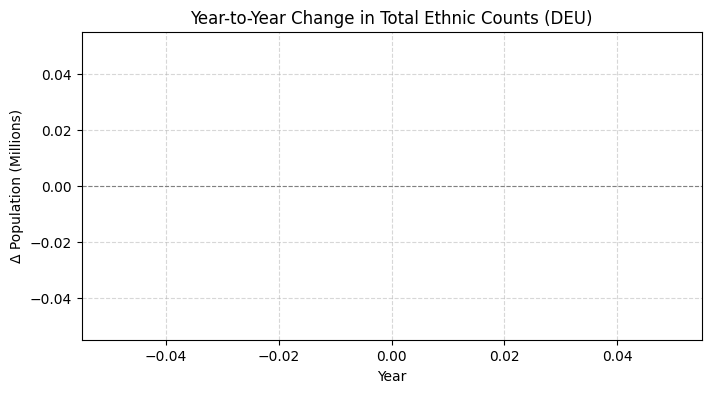


====== MYS ======


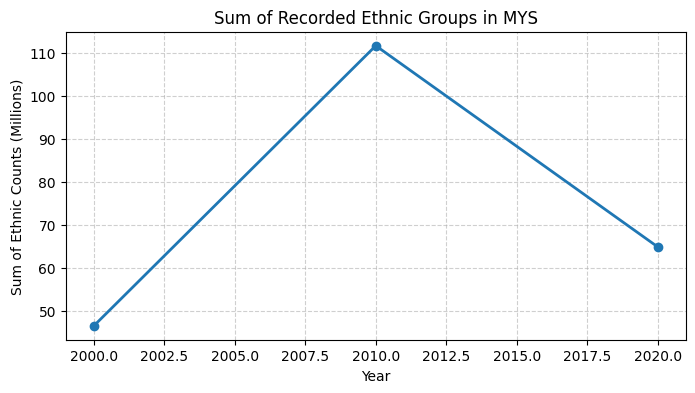

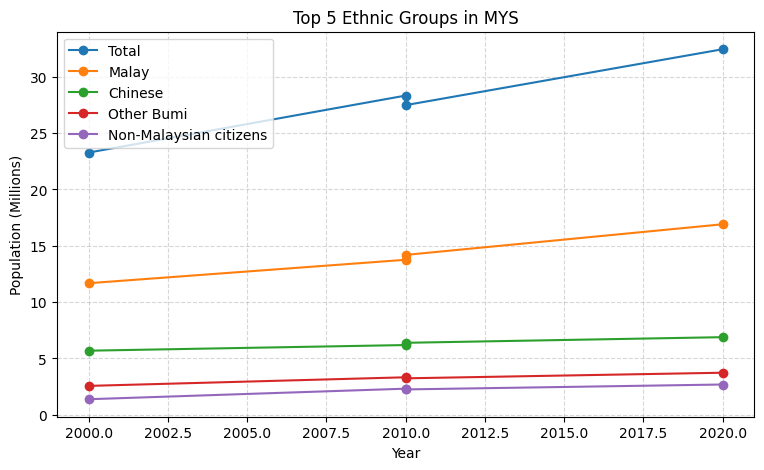

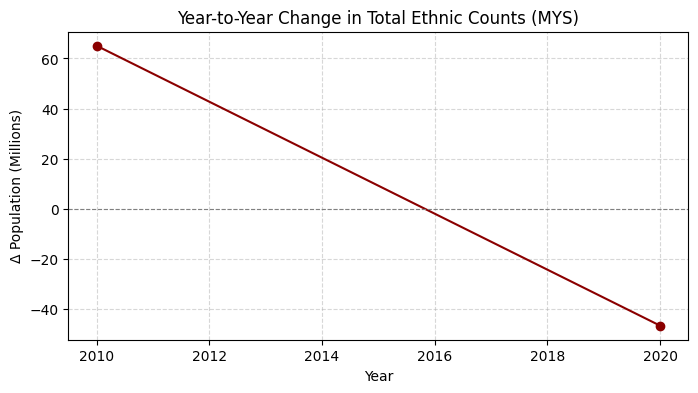

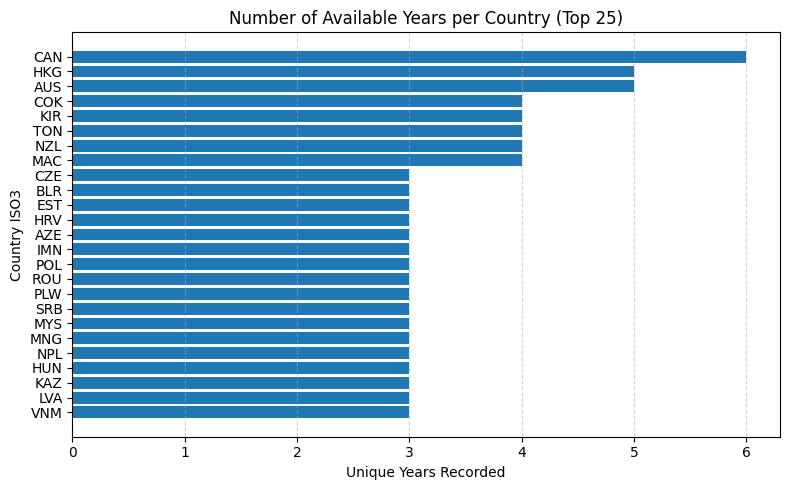

,iso3,year
20,CAN,6
43,HKG,5
8,AUS,5
23,COK,4
54,KIR,4
...,...,...
96,TTO,1
104,VGB,1
103,VEN,1
102,VCT,1


In [29]:
for iso in ["USA","DEU","MYS"]:
    print("\n======", iso, "======")
    plot_total_ethnic_sum(ethnic, iso)
    plot_major_ethnic_trends(ethnic, iso, top_n=5)
    plot_ethnic_outlier_check(ethnic, iso)

# Global coverage view
plot_ethnic_coverage(ethnic)

# **EDA for the IMS Stock Dataset**

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, country_converter as coco
pd.set_option("display.max_columns", 100)

In [4]:
ims = pd.read_csv(Path_IMS, dtype={"iso3_dest":str, "iso3_orig":str})
ims.columns = [c.strip().lower().replace(" ","_") for c in ims.columns]
ims["year"]  = pd.to_numeric(ims["year"], errors="coerce").astype("Int64")
ims["value"] = pd.to_numeric(ims["value"], errors="coerce")
ims = ims.dropna(subset=["iso3_dest","iso3_orig","year","value"])
print("Rows:", len(ims), "| Destinations:", ims['iso3_dest'].nunique(), "| Origins:", ims['iso3_orig'].nunique())

Rows: 72983 | Destinations: 215 | Origins: 216


## 1. Total migrant stock over time (1990–2024)

In [5]:
def plot_total_inflow_trend(ims_df, dest_iso3):
    total = (ims_df[ims_df["iso3_dest"]==dest_iso3]
             .groupby("year", as_index=False)["value"].sum()
             .sort_values("year"))
    plt.figure(figsize=(8,4))
    plt.plot(total["year"], total["value"]/1e6, marker="o", linewidth=2)
    plt.title(f"Total Migrant Stock into {dest_iso3} (1990–2024)")
    plt.xlabel("Year")
    plt.ylabel("Migrant Stock (Millions)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

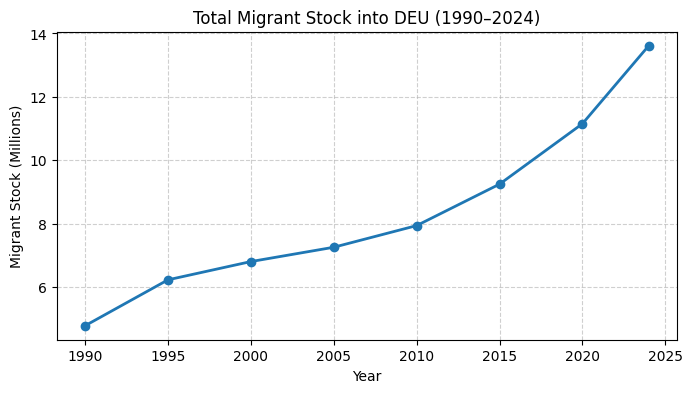

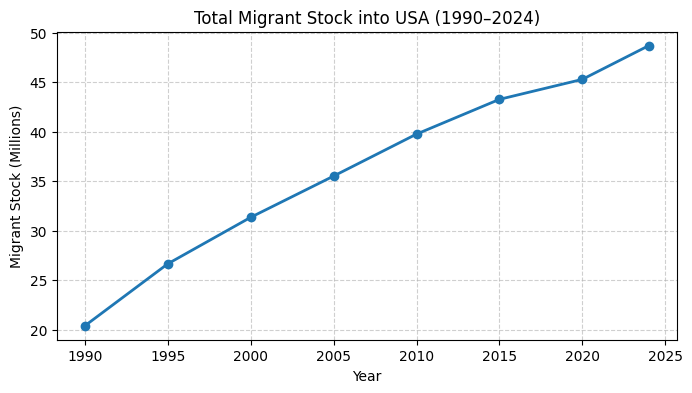

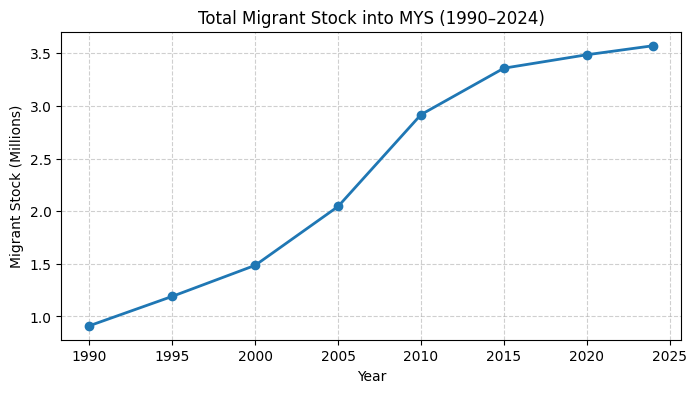

In [6]:
plot_total_inflow_trend(ims, "DEU")
plot_total_inflow_trend(ims, "USA")
plot_total_inflow_trend(ims, "MYS")

## 2. Top 10 origin countries for each destination (2024)

In [7]:
def plot_top_origins_2024(ims_df, dest_iso3, top_n=10):
    df = ims_df[(ims_df["iso3_dest"]==dest_iso3) & (ims_df["year"]==2024)]
    top = (df.groupby("iso3_orig", as_index=False)["value"].sum()
             .sort_values("value", ascending=False).head(top_n))
    plt.figure(figsize=(8,4))
    plt.barh(top["iso3_orig"], top["value"]/1e6)
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Origins → {dest_iso3} (2024)")
    plt.xlabel("Migrant Stock (Millions)")
    plt.ylabel("Origin ISO3")
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

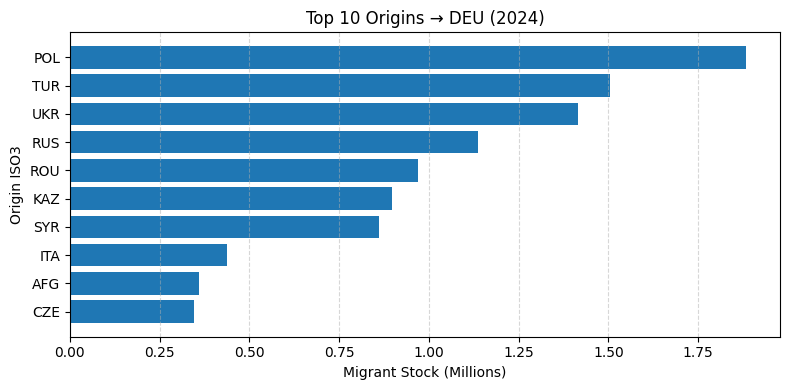

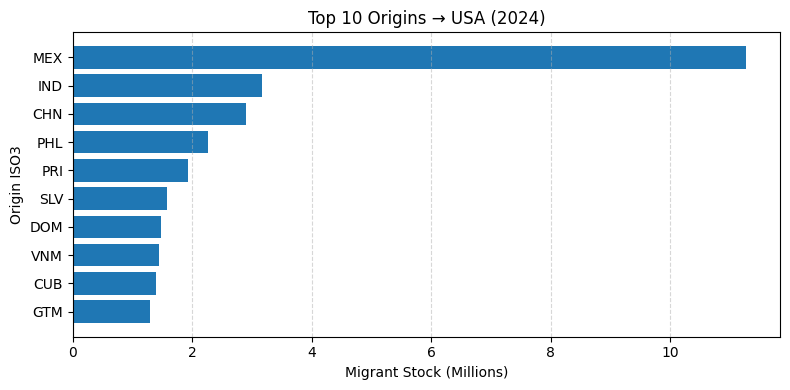

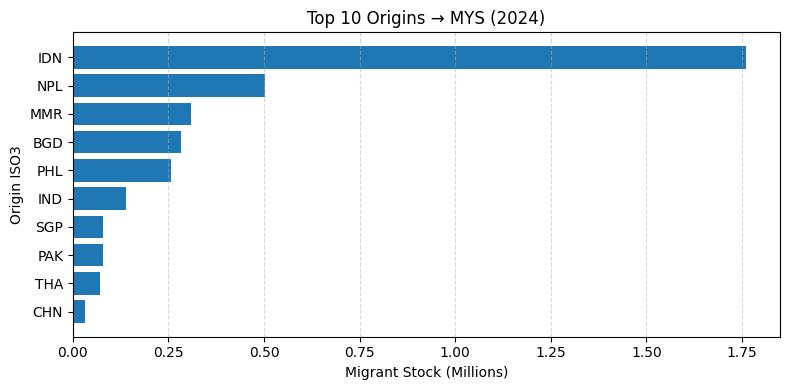

In [8]:
plot_top_origins_2024(ims, "DEU")
plot_top_origins_2024(ims, "USA")
plot_top_origins_2024(ims, "MYS")

## 3. Change of Origins Overtime

In [9]:
def plot_top_origin_trends(ims_df, dest_iso3, top_n=5):
    # Identify top-N overall origins across all years
    top = (ims_df[ims_df["iso3_dest"]==dest_iso3]
           .groupby("iso3_orig", as_index=False)["value"].sum()
           .sort_values("value", ascending=False).head(top_n)["iso3_orig"].tolist())

    sub = ims_df[(ims_df["iso3_dest"]==dest_iso3) & (ims_df["iso3_orig"].isin(top))]
    trends = (sub.groupby(["year","iso3_orig"], as_index=False)["value"].sum())

    plt.figure(figsize=(9,5))
    for o in top:
        d = trends[trends["iso3_orig"]==o]
        plt.plot(d["year"], d["value"]/1e6, marker="o", label=o)
    plt.title(f"Top {top_n} Origins → {dest_iso3} (1990–2024)")
    plt.xlabel("Year"); plt.ylabel("Migrant Stock (Millions)")
    plt.grid(True, linestyle="--", alpha=0.6); plt.legend()
    plt.show()

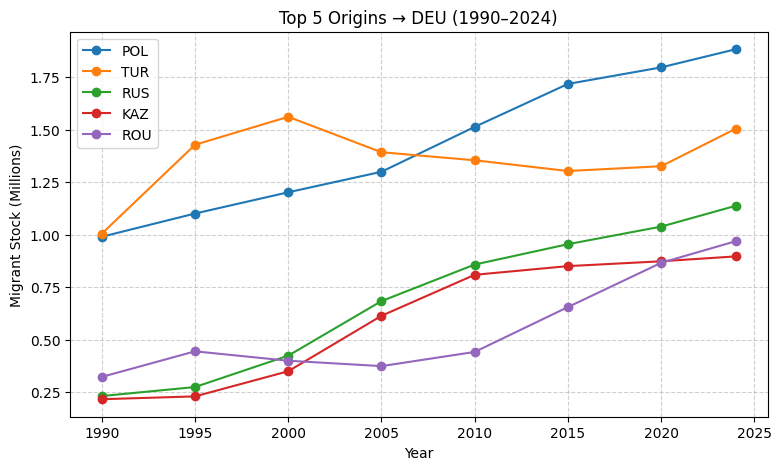

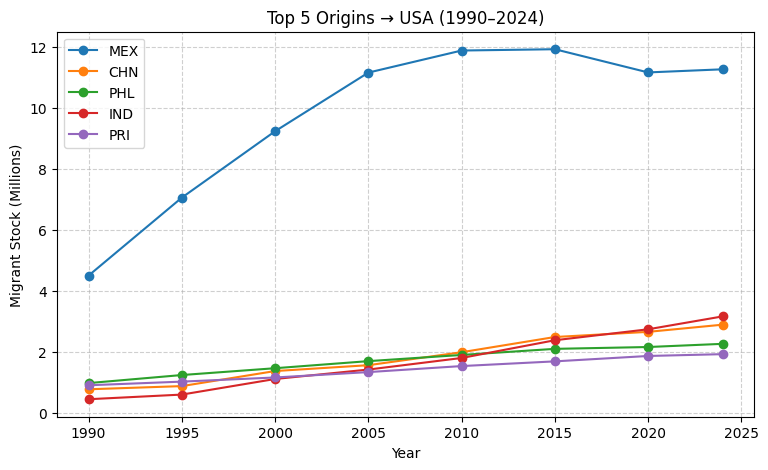

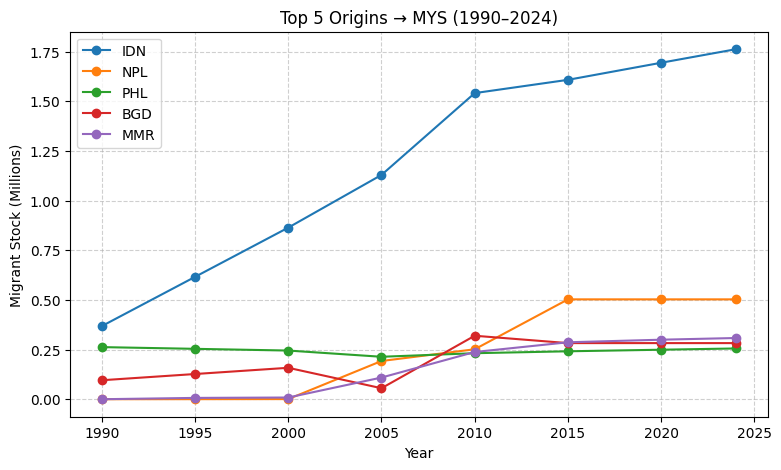

In [10]:
plot_top_origin_trends(ims, "DEU", top_n=5)
plot_top_origin_trends(ims, "USA", top_n=5)
plot_top_origin_trends(ims, "MYS", top_n=5)

## 4. Which destinations have the largest total stocks overall

In [11]:
def plot_top_destinations_total(ims_df, top_n=15):
    total = (ims_df.groupby("iso3_dest", as_index=False)["value"]
             .sum().sort_values("value", ascending=False).head(top_n))
    plt.figure(figsize=(8,5))
    plt.barh(total["iso3_dest"], total["value"]/1e6)
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Destinations by Total Migrant Stock (1990–2024)")
    plt.xlabel("Total Stock (Millions)"); plt.ylabel("Destination ISO3")
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout(); plt.show()


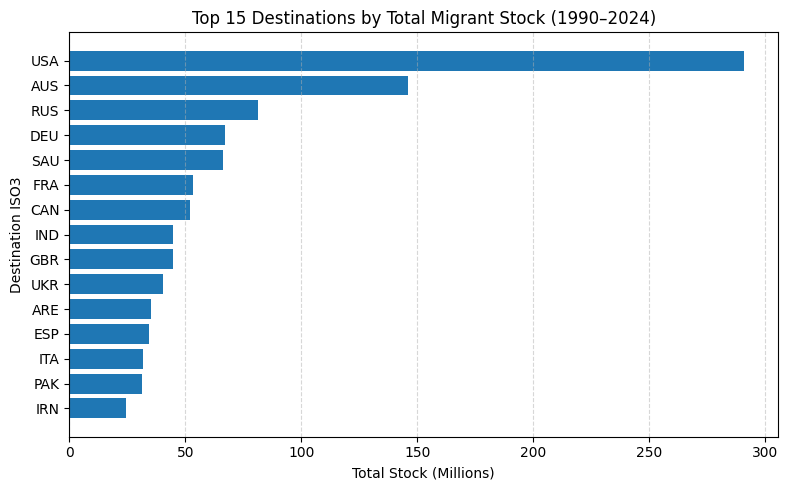

In [12]:
plot_top_destinations_total(ims)

## 5. Missing or inconsistent years per destination

In [13]:
def plot_missingness_heatmap(ims_df, sample_dest=20):
    pivot = ims_df.pivot_table(index="iso3_dest", columns="year",
                               values="value", aggfunc="sum")
    pivot = pivot.notna().astype(int)
    # Limit to top N for readability
    top = pivot.sample(min(sample_dest, len(pivot)), random_state=42)
    plt.figure(figsize=(10,6))
    sns.heatmap(top, cmap="Greens", cbar=False, linewidths=0.1)
    plt.title("Data Availability by Destination and Year (1=Available)")
    plt.xlabel("Year"); plt.ylabel("Destination")
    plt.tight_layout(); plt.show()

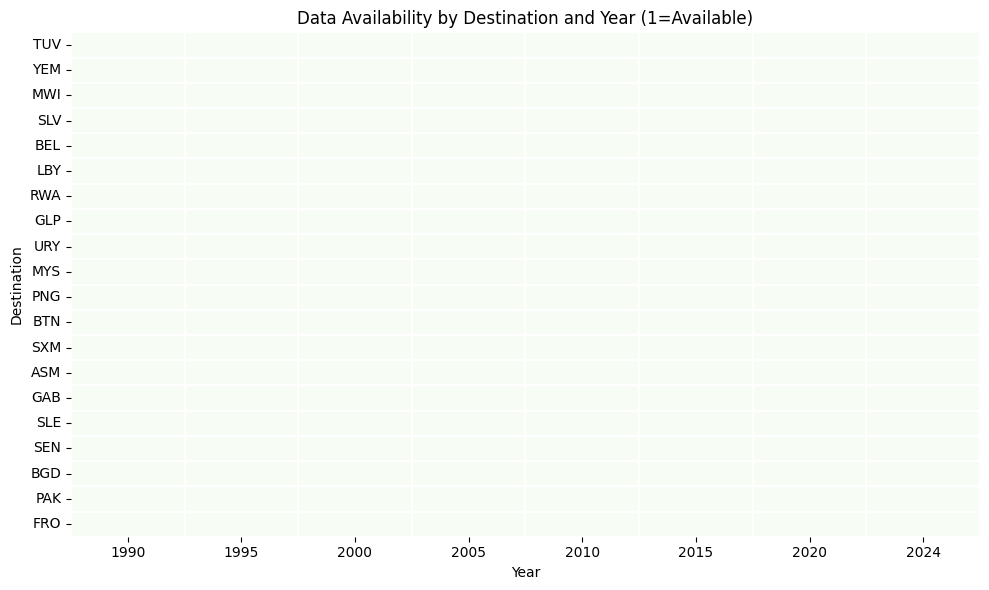

In [14]:
plot_missingness_heatmap(ims)

## Summary


====== USA ======


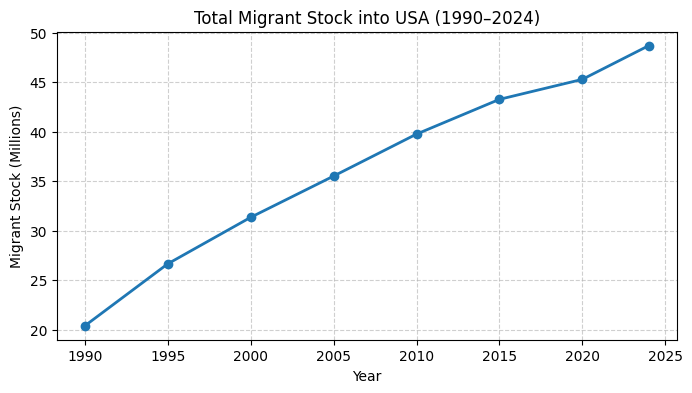

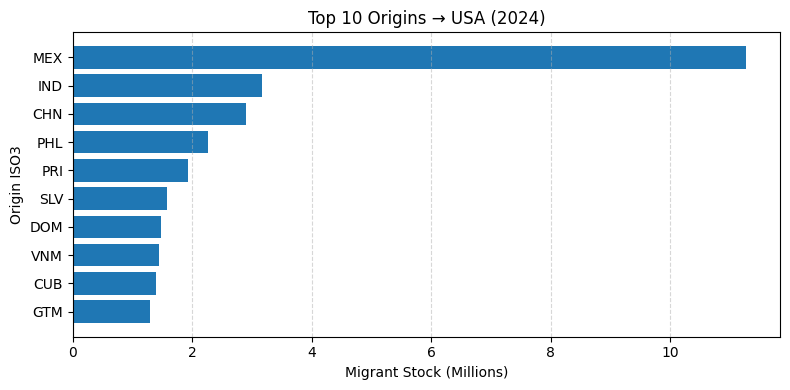

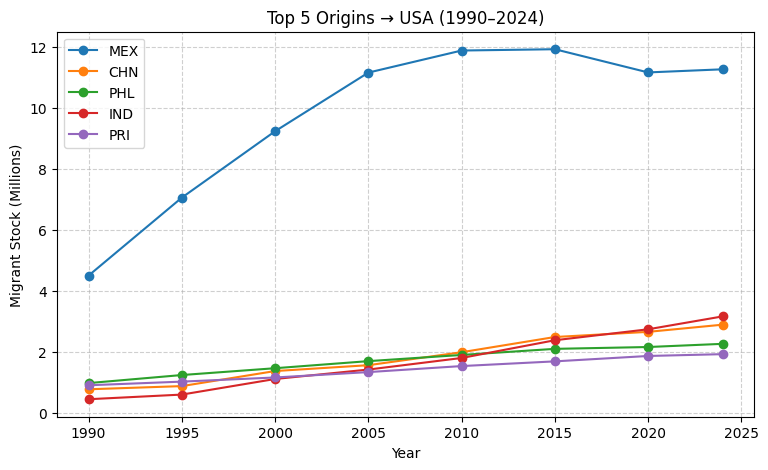


====== DEU ======


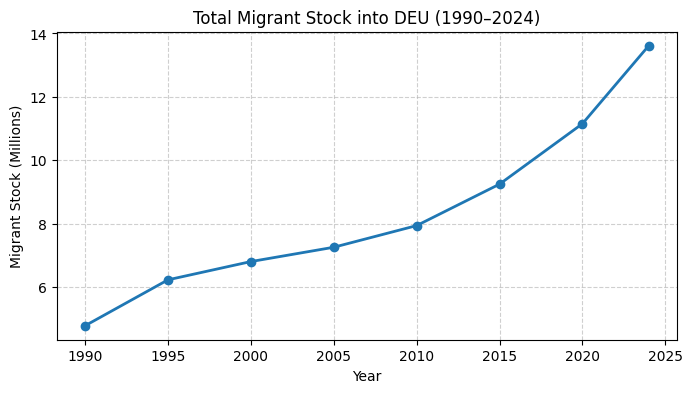

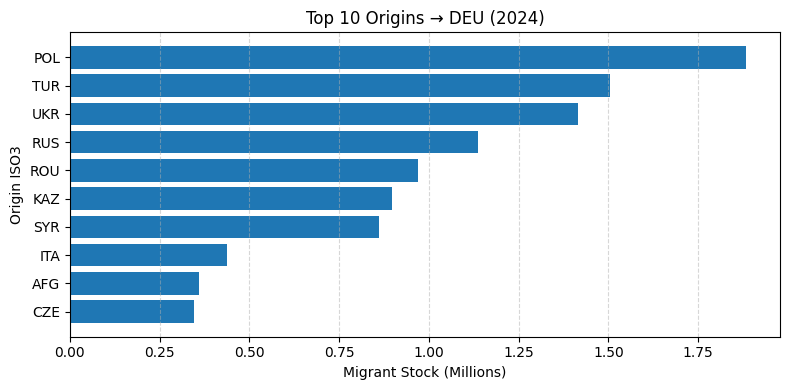

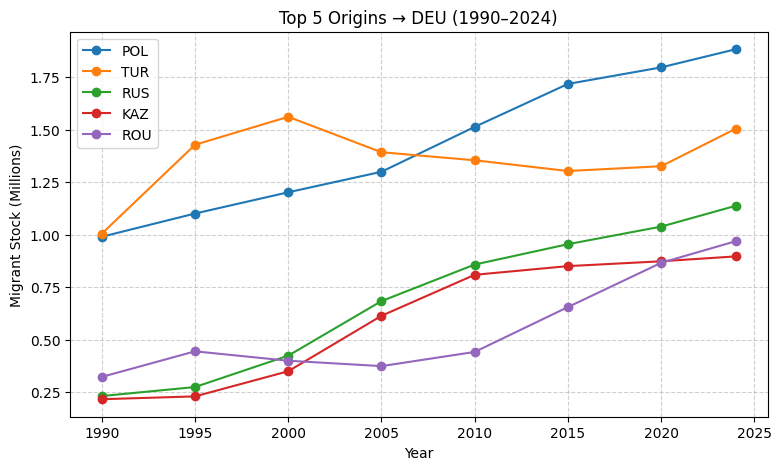


====== SAU ======


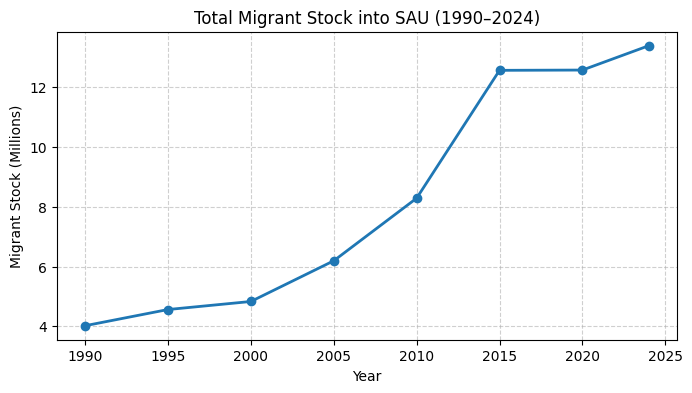

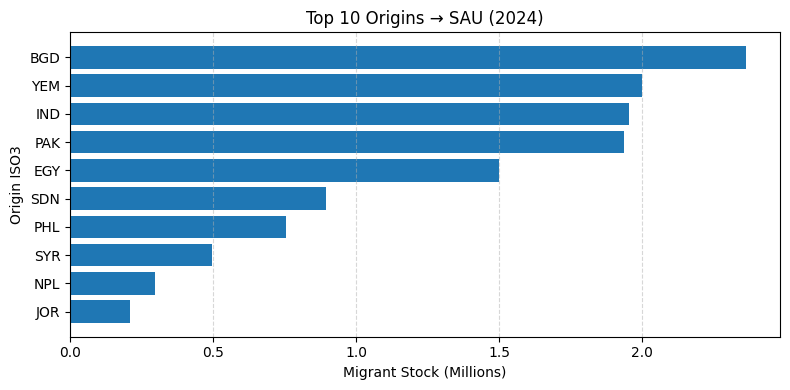

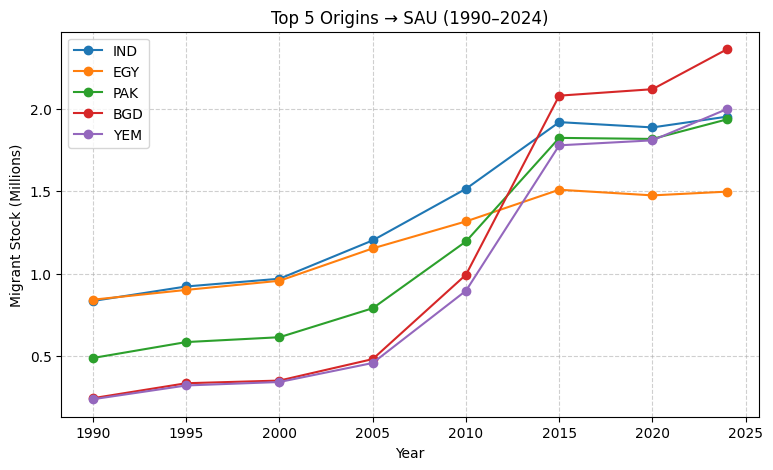

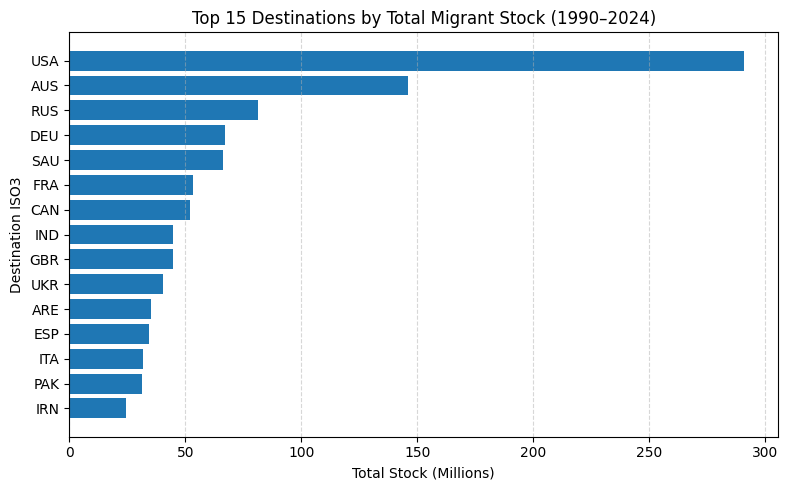

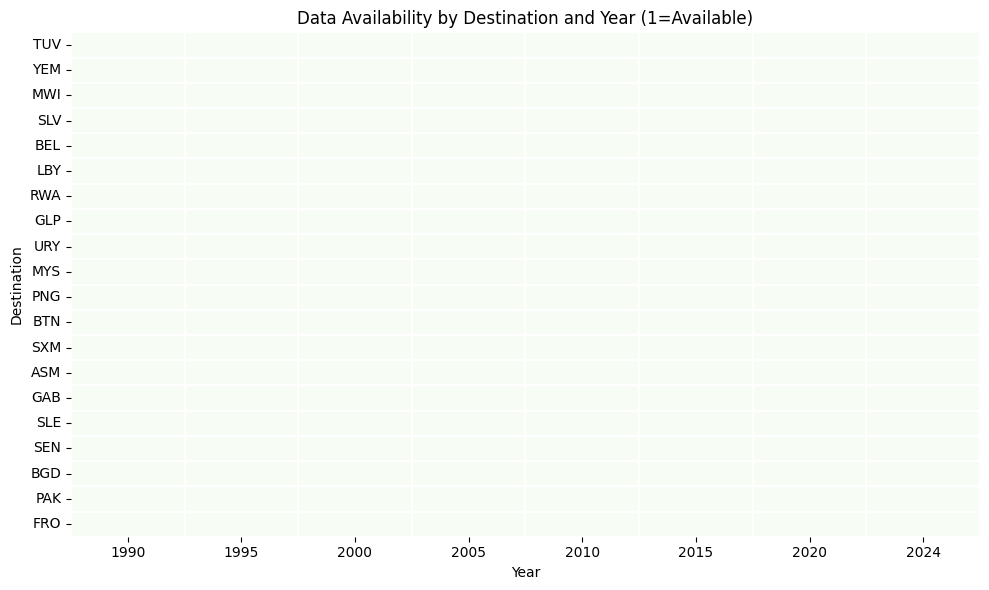

In [15]:
# === Quick execution example for your 3 study destinations ===
for dest in ["USA","DEU","SAU"]:
    print("\n======", dest, "======")
    plot_total_inflow_trend(ims, dest)
    plot_top_origins_2024(ims, dest)
    plot_top_origin_trends(ims, dest, top_n=5)

# Overview of destinations and missingness
plot_top_destinations_total(ims)
plot_missingness_heatmap(ims)

# **Cross-Dataset Relationship EDA**

## Setup

In [30]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, country_converter as coco
pd.set_option("display.max_columns", 100)

In [31]:
ims = pd.read_csv(Path_IMS, dtype={"iso3_dest":str, "iso3_orig":str})
ims.columns = [c.strip().lower().replace(" ","_") for c in ims.columns]
ims["year"]  = pd.to_numeric(ims["year"], errors="coerce").astype("Int64")
ims["value"] = pd.to_numeric(ims["value"], errors="coerce")
ims = ims.dropna(subset=["iso3_dest","iso3_orig","year","value"])
print("Rows:", len(ims), "| Destinations:", ims['iso3_dest'].nunique(), "| Origins:", ims['iso3_orig'].nunique())

Rows: 72983 | Destinations: 215 | Origins: 216


In [32]:
ethnic = pd.read_csv(Path_Ethnic, dtype={"iso3":str})
ethnic.columns = [c.strip().lower().replace(" ","_") for c in ethnic.columns]
ethnic["year"]  = pd.to_numeric(ethnic["year"], errors="coerce").astype("Int64")
ethnic["value"] = pd.to_numeric(ethnic["value"], errors="coerce")
ethnic = ethnic.dropna(subset=["iso3","year","ethnic_group","value"])
print("Rows:", len(ethnic), "| Countries:", ethnic['iso3'].nunique(), "| Years:", ethnic['year'].min(), "→", ethnic['year'].max())

Rows: 7897 | Countries: 109 | Years: 1995 → 2023


## Dataset Overlap

Find countries available in both datasets

In [59]:
def get_common_countries(ims_df, ethnic_df):
    """
    Finds countries present as destination (IMS) and as country (Ethnic).
    Returns both list and DataFrame with basic info.
    """
    ims_countries = set(ims_df["iso3_dest"].unique())
    eth_countries = set(ethnic_df["iso3"].unique())
    common = sorted(ims_countries.intersection(eth_countries))
    print(f"Countries available in both datasets: {len(common)}")
    return common

In [61]:
common_countries = get_common_countries(ims, ethnic)
print(common_countries)  # show first 20

Countries available in both datasets: 101
['ABW', 'AIA', 'ALB', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AZE', 'BGD', 'BGR', 'BHR', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'CAN', 'CHL', 'CHN', 'COK', 'COL', 'CRI', 'CUB', 'CYP', 'CZE', 'DMA', 'ECU', 'EGY', 'EST', 'ETH', 'FJI', 'FLK', 'GBR', 'GEO', 'GHA', 'GIB', 'GRD', 'GUM', 'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IRL', 'IRN', 'JAM', 'KAZ', 'KEN', 'KGZ', 'KIR', 'KWT', 'LAO', 'LBR', 'LCA', 'LKA', 'LTU', 'LVA', 'MAC', 'MCO', 'MDA', 'MKD', 'MNE', 'MNG', 'MOZ', 'MYS', 'NER', 'NIU', 'NPL', 'NZL', 'PER', 'PHL', 'PLW', 'POL', 'PRI', 'PSE', 'ROU', 'RUS', 'SGP', 'SLV', 'SRB', 'SUR', 'SVK', 'SVN', 'THA', 'TJK', 'TKL', 'TON', 'TTO', 'TUV', 'UGA', 'UKR', 'URY', 'USA', 'VEN', 'VGB', 'VNM', 'VUT', 'ZMB']


Among countries present in both datasets, rank them by total immigrant stock.

In [65]:
def rank_countries_by_inflow(ims_df, common_list, top_n=20):

    sub = ims_df[ims_df["iso3_dest"].isin(common_list)]
    totals = (sub.groupby("iso3_dest", as_index=False)["value"]
              .sum().sort_values("value", ascending=False))
    totals["value_million"] = totals["value"]/1e6

    print(f"Top {top_n} countries by total immigrant stock (That is present in both dataset):")
    display(totals.head(top_n))

    plt.figure(figsize=(8,5))
    plt.barh(totals["iso3_dest"].head(top_n), totals["value_million"].head(top_n))
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Destinations by Total Immigrant Stock\n(countries present in both datasets)")
    plt.xlabel("Total Immigrants (Millions)")
    plt.ylabel("Destination ISO3")
    plt.grid(True, axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return totals

Top 20 countries by total immigrant stock (common only):


,iso3_dest,value,value_million
95,USA,291039170.0,291.039170
7,AUS,146028099.0,146.028099
79,RUS,81245999.0,81.245999
19,CAN,52246823.0,52.246823
35,GBR,44507507.0,44.507507
93,UKR,40266239.0,40.266239
47,IRN,24235389.0,24.235389
41,HKG,20662898.0,20.662898
67,MYS,18968771.0,18.968771
49,KAZ,16004853.0,16.004853


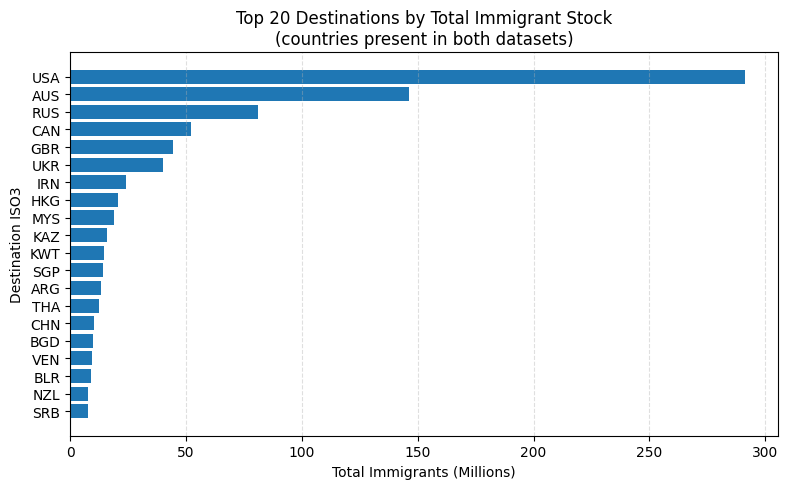

In [63]:
ranked_common = rank_countries_by_inflow(ims, common_countries, top_n=20)

## Compare Year Coverage by Country (IMS vs Ethnic)

In [67]:
def compare_years_by_country(ims_df, ethnic_df, iso_list):
    """
    Prints and plots which years exist in IMS vs Ethnic datasets
    for the given list of ISO3 countries.
    """
    for iso in iso_list:
        print(f"\n=== {iso} ===")
        ims_years = sorted(ims_df[ims_df["iso3_dest"]==iso]["year"].dropna().unique().tolist())
        eth_years = sorted(ethnic_df[ethnic_df["iso3"]==iso]["year"].dropna().unique().tolist())
        print(f"IMS years   ({len(ims_years)}): {ims_years}")
        print(f"Ethnic years ({len(eth_years)}): {eth_years}")

        # Optional: quick visual overlap plot
        plt.figure(figsize=(6,1.8))
        plt.eventplot([ims_years, eth_years],
                      colors=["steelblue","darkorange"],
                      lineoffsets=[1,0],
                      linelengths=0.4)
        plt.yticks([0,1], ["Ethnic","IMS"])
        plt.xlabel("Year"); plt.title(f"Year Coverage — {iso}")
        plt.grid(True, axis="x", linestyle="--", alpha=0.4)
        plt.tight_layout(); plt.show()



=== USA ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (3): [2000, 2010, 2020]


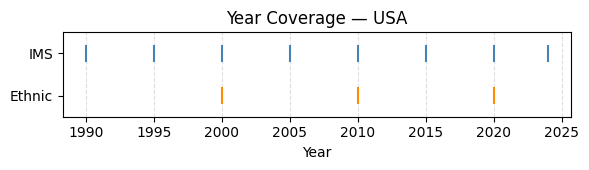


=== AUS ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (5): [2001, 2006, 2011, 2016, 2021]


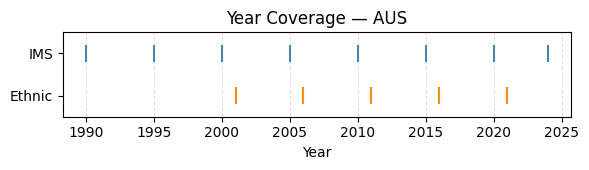


=== MYS ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (3): [2000, 2010, 2020]


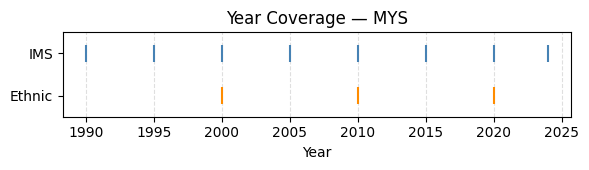


=== RUS ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (1): [2010]


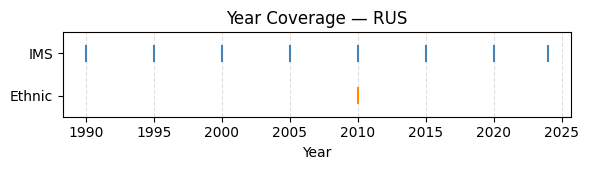


=== CAN ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (6): [1996, 2001, 2006, 2011, 2016, 2021]


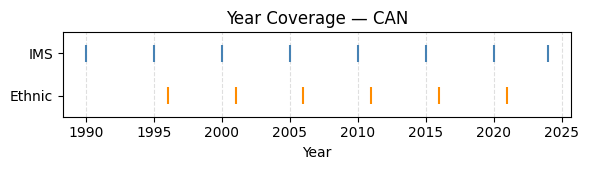


=== GBR ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (2): [2001, 2011]


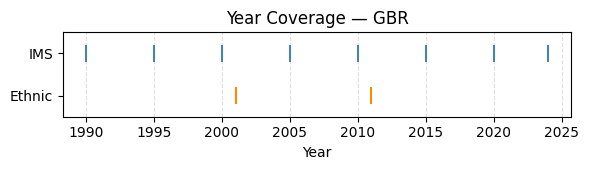


=== UKR ===
IMS years   (8): [1990, 1995, 2000, 2005, 2010, 2015, 2020, 2024]
Ethnic years (1): [2001]


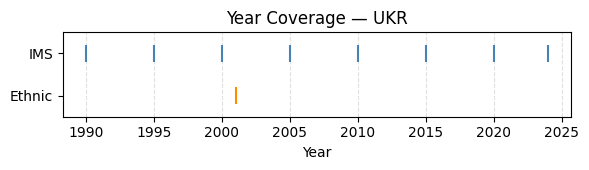

In [70]:
compare_years_by_country(ims, ethnic, ["USA","AUS","MYS","RUS","CAN","GBR","UKR"])

## 1. Does migration inflow correlate with growth in minority ethnic groups?

Overlay total migrant inflow vs. chosen ethnic-group count.
Shows potential correlation between migration and ethnic growth.

In [33]:
def plot_inflow_vs_ethnic_corr(ims_df, ethnic_df, dest_iso3, ethnic_group):

    inflow = (ims_df[ims_df["iso3_dest"]==dest_iso3]
              .groupby("year", as_index=False)["value"].sum()
              .rename(columns={"value":"total_inflow"}))

    e_grp = (ethnic_df[(ethnic_df["iso3"]==dest_iso3) &
                       (ethnic_df["ethnic_group"].str.lower()==ethnic_group.lower())]
             .groupby("year", as_index=False)["value"].sum()
             .rename(columns={"value":"ethnic_value"}))

    m = inflow.merge(e_grp, on="year", how="inner")
    if m.empty:
        print(f"No overlap for {dest_iso3}-{ethnic_group}")
        return

    corr = m["total_inflow"].corr(m["ethnic_value"])
    print(f"Pearson r ≈ {corr:.3f}")

    plt.figure(figsize=(9,4))
    plt.plot(m["year"], m["total_inflow"]/1e6, "o-", label="Migration Inflow (M persons)")
    plt.plot(m["year"], m["ethnic_value"]/1e6, "s-", label=f"{ethnic_group} Count (M persons)")
    plt.title(f"Inflow vs. {ethnic_group} in {dest_iso3} | r = {corr:.2f}")
    plt.xlabel("Year"); plt.ylabel("Millions"); plt.grid(True, ls="--", alpha=.5); plt.legend()
    plt.show()


In [34]:
plot_inflow_vs_ethnic_corr(ims, ethnic, "DEU", "Turkish")
plot_inflow_vs_ethnic_corr(ims, ethnic, "USA", "Hispanic")

No overlap for DEU-Turkish
No overlap for USA-Hispanic


## 2. Are periods of high inflow followed by visible ethnic change (lag effect)?

Computes correlation between inflow and ethnic counts for lags 0→max_lag years.Lag 1 = migration precedes ethnic change by 1 year.

In [35]:
def plot_lag_correlation(ims_df, ethnic_df, dest_iso3, ethnic_group, max_lag=5):

    inflow = (ims_df[ims_df["iso3_dest"]==dest_iso3]
              .groupby("year", as_index=False)["value"].sum()
              .rename(columns={"value":"total_inflow"}))

    e_grp = (ethnic_df[(ethnic_df["iso3"]==dest_iso3) &
                       (ethnic_df["ethnic_group"].str.lower()==ethnic_group.lower())]
             .groupby("year", as_index=False)["value"].sum()
             .rename(columns={"value":"ethnic_value"}))

    m = inflow.merge(e_grp, on="year", how="inner").sort_values("year")

    if len(m)<3:
        print("Not enough overlapping points"); return

    inflow_series = m["total_inflow"].values
    ethnic_series = m["ethnic_value"].values
    lags, corrs = [], []

    for k in range(max_lag+1):
        if len(inflow_series[k:])<3: break
        r = np.corrcoef(inflow_series[:-k or None], ethnic_series[k:] if k>0 else ethnic_series)[0,1]
        lags.append(k); corrs.append(r)

    plt.figure(figsize=(7,4))
    plt.bar(lags, corrs, color="teal")
    plt.title(f"Lag Correlation (0 = same year) — {dest_iso3} / {ethnic_group}")
    plt.xlabel("Lag (years, migration → ethnicity)"); plt.ylabel("Correlation r")
    plt.axhline(0, color="gray", ls="--"); plt.show()


In [36]:
plot_lag_correlation(ims, ethnic, "DEU", "Turkish", max_lag=5)

Not enough overlapping points


## 3. Is the timescale consistent — years align between datasets?

In [37]:
def check_year_alignment(ims_df, ethnic_df):
    """
    Prints intersection of years per destination to ensure datasets align.
    """
    common_countries = sorted(set(ims_df["iso3_dest"]).intersection(ethnic_df["iso3"]))
    print("Shared destinations:", len(common_countries))
    for c in common_countries[:10]:
        yrs_ims = sorted(ims_df[ims_df["iso3_dest"]==c]["year"].unique())
        yrs_eth = sorted(ethnic_df[ethnic_df["iso3"]==c]["year"].unique())
        overlap = sorted(set(yrs_ims).intersection(yrs_eth))
        print(f"{c}: IMS {yrs_ims[0]}–{yrs_ims[-1]} | Ethnic {yrs_eth[0]}–{yrs_eth[-1]} | Overlap {len(overlap)} years")

    return common_countries

aligned_countries = check_year_alignment(ims, ethnic)


Shared destinations: 101
ABW: IMS 1990–2024 | Ethnic 2000–2010 | Overlap 2 years
AIA: IMS 1990–2024 | Ethnic 2001–2001 | Overlap 0 years
ALB: IMS 1990–2024 | Ethnic 2011–2023 | Overlap 0 years
ARG: IMS 1990–2024 | Ethnic 2022–2022 | Overlap 0 years
ARM: IMS 1990–2024 | Ethnic 2001–2022 | Overlap 0 years
ASM: IMS 1990–2024 | Ethnic 2000–2000 | Overlap 1 years
ATG: IMS 1990–2024 | Ethnic 2001–2011 | Overlap 0 years
AUS: IMS 1990–2024 | Ethnic 2001–2021 | Overlap 0 years
AZE: IMS 1990–2024 | Ethnic 1999–2019 | Overlap 0 years
BGD: IMS 1990–2024 | Ethnic 2022–2022 | Overlap 0 years


# **Quantitative Checks**

## Setup

In [38]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, country_converter as coco
pd.set_option("display.max_columns", 100)

In [39]:
ims = pd.read_csv(Path_IMS, dtype={"iso3_dest":str, "iso3_orig":str})
ims.columns = [c.strip().lower().replace(" ","_") for c in ims.columns]
ims["year"]  = pd.to_numeric(ims["year"], errors="coerce").astype("Int64")
ims["value"] = pd.to_numeric(ims["value"], errors="coerce")
ims = ims.dropna(subset=["iso3_dest","iso3_orig","year","value"])
print("Rows:", len(ims), "| Destinations:", ims['iso3_dest'].nunique(), "| Origins:", ims['iso3_orig'].nunique())

Rows: 72983 | Destinations: 215 | Origins: 216


In [40]:
ethnic = pd.read_csv(Path_Ethnic, dtype={"iso3":str})
ethnic.columns = [c.strip().lower().replace(" ","_") for c in ethnic.columns]
ethnic["year"]  = pd.to_numeric(ethnic["year"], errors="coerce").astype("Int64")
ethnic["value"] = pd.to_numeric(ethnic["value"], errors="coerce")
ethnic = ethnic.dropna(subset=["iso3","year","ethnic_group","value"])
print("Rows:", len(ethnic), "| Countries:", ethnic['iso3'].nunique(), "| Years:", ethnic['year'].min(), "→", ethnic['year'].max())

Rows: 7897 | Countries: 109 | Years: 1995 → 2023


In [41]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import zscore

## 1 Year Coverage per Destination–Country

Quantifies how many unique years are available for each dataset.
Helps identify countries with long enough history for time-series.

In [42]:
def year_coverage_summary(ims_df, ethnic_df):
    """
    Quantifies how many unique years are available for each dataset.
    Helps identify countries with long enough history for time-series.
    """
    ims_cov = ims_df.groupby("iso3_dest")["year"].nunique().reset_index(name="ims_years")
    eth_cov = ethnic_df.groupby("iso3")["year"].nunique().reset_index(name="ethnic_years")
    cov = ims_cov.merge(eth_cov, left_on="iso3_dest", right_on="iso3", how="outer")
    cov = cov.fillna(0).sort_values("ims_years", ascending=False)

    plt.figure(figsize=(8,5))
    sns.scatterplot(data=cov, x="ims_years", y="ethnic_years")
    plt.title("Year Coverage Comparison (IMS vs Ethnic)")
    plt.xlabel("IMS Years Available"); plt.ylabel("Ethnic Years Available")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()
    return cov

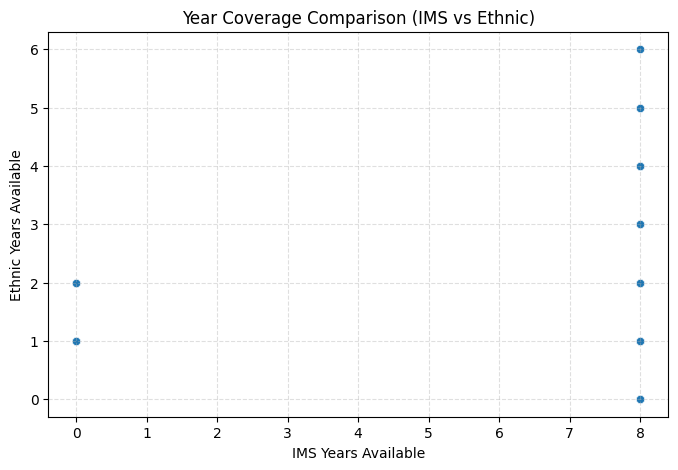

,iso3_dest,ims_years,iso3,ethnic_years
0,ABW,8.0,ABW,2.0
1,AFG,8.0,0,0.0
2,AGO,8.0,0,0.0
3,AIA,8.0,AIA,1.0
5,ALB,8.0,ALB,2.0


In [43]:
coverage = year_coverage_summary(ims, ethnic)
coverage.head()

## 2. Migration Growth Rate


Calculates year-to-year migration growth rate for a destination:

    g_t = (V_t − V_{t−1}) / V_{t−1}

In [44]:
def migration_growth_rate(ims_df, dest_iso3):

    d = (ims_df[ims_df["iso3_dest"]==dest_iso3]
         .groupby("year", as_index=False)["value"].sum()
         .sort_values("year"))
    d["growth_rate"] = d["value"].pct_change()*100
    plt.figure(figsize=(8,4))
    plt.plot(d["year"], d["growth_rate"], marker="o")
    plt.title(f"Migration Growth Rate — {dest_iso3}")
    plt.xlabel("Year"); plt.ylabel("Growth Rate (%)")
    plt.axhline(0,color="gray",ls="--"); plt.grid(True,alpha=.4)
    plt.show()
    return d

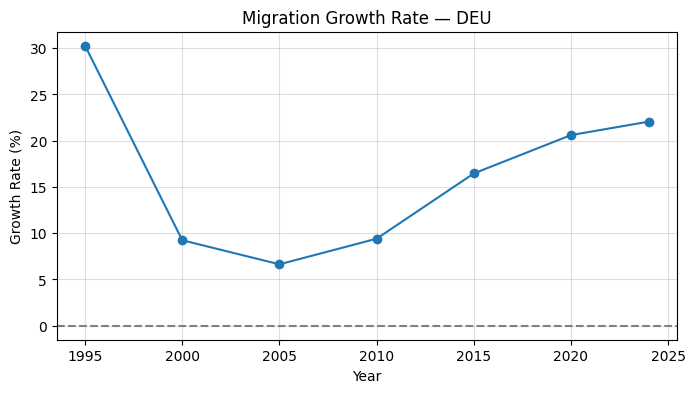

,year,value,growth_rate
0,1990,4782033.0,NaN
1,1995,6229569.0,30.270306
2,2000,6805232.0,9.240816
3,2005,7257007.0,6.638642
4,2010,7939669.0,9.406936
5,2015,9246694.0,16.461958
6,2020,11152330.0,20.608836
7,2024,13612825.0,22.062609


In [45]:
migration_growth_rate(ims, "DEU")

## 3. Ethnic Diversity Index (Shannon Entropy)

In [46]:
def compute_diversity_index(ethnic_df):
    def shannon(sub):
        p = sub["value"] / sub["value"].sum()
        return -np.sum(p * np.log(p))
    return (ethnic_df.groupby(["iso3","year"], as_index=False)
            .apply(lambda g: pd.Series({"diversity_index": shannon(g)})))

def plot_diversity_distribution(div_df):
    plt.figure(figsize=(7,4))
    sns.histplot(div_df["diversity_index"], bins=25, kde=True)
    plt.title("Distribution of Ethnic Diversity Index (Shannon H)")
    plt.xlabel("Diversity Index H"); plt.ylabel("Frequency")
    plt.grid(True,alpha=.3); plt.show()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-2318544959.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"diversity_index": shannon(g)})))


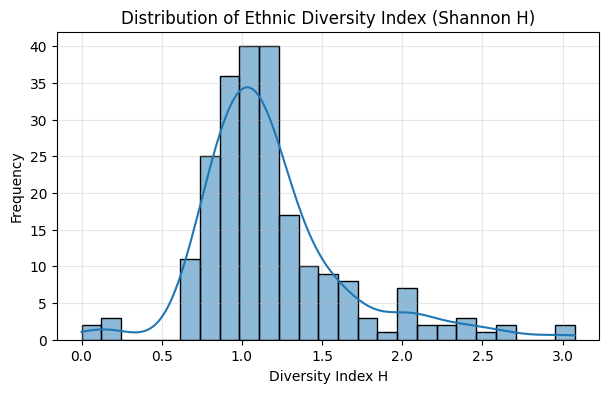

In [47]:
div = compute_diversity_index(ethnic)
plot_diversity_distribution(div)

## 4. Lag Correlation (Does Migration Lead Ethnic Change?)

In [48]:
def lag_corr_total(ims_df, ethnic_df, dest_iso3, max_lag=5):
    """
    Computes correlation between total inflow and total ethnic count
    for lags 0 → max_lag years.
    """
    inflow = (ims_df[ims_df["iso3_dest"]==dest_iso3]
              .groupby("year", as_index=False)["value"].sum()
              .rename(columns={"value":"inflow"}))
    ethnic_sum = (ethnic_df[ethnic_df["iso3"]==dest_iso3]
                  .groupby("year", as_index=False)["value"].sum()
                  .rename(columns={"value":"ethnic_total"}))
    m = inflow.merge(ethnic_sum, on="year", how="inner").sort_values("year")
    if len(m)<3:
        print("Insufficient overlap"); return
    inflow_s, ethnic_s = m["inflow"].values, m["ethnic_total"].values
    corrs=[]
    for k in range(max_lag+1):
        r = np.corrcoef(inflow_s[:-k or None], ethnic_s[k:] if k>0 else ethnic_s)[0,1]
        corrs.append(r)
    plt.figure(figsize=(7,4))
    plt.bar(range(max_lag+1), corrs, color="teal")
    plt.title(f"Lag Correlation IMS→Ethnic ({dest_iso3})")
    plt.xlabel("Lag (years)"); plt.ylabel("Correlation r")
    plt.axhline(0,color="gray",ls="--"); plt.show()
    return pd.DataFrame({"lag":range(max_lag+1),"corr":corrs})


In [49]:
lag_corr_total(ims, ethnic, "DEU", max_lag=5)

Insufficient overlap


## 5. Outlier Detection (Z-score / IQR)

In [50]:
def detect_outliers(df, group_cols, value_col, method="zscore", threshold=3):
    """
    Flags outliers in value_col within each group (country/year).
    method: "zscore" or "iqr"
    """
    df = df.copy()
    def zflag(x):
        z = zscore(x[value_col], nan_policy='omit')
        return np.abs(z)>threshold
    def iqrflag(x):
        q1,q3 = x[value_col].quantile([.25,.75])
        iqr = q3-q1
        return (x[value_col]<q1-1.5*iqr)|(x[value_col]>q3+1.5*iqr)
    flag_func = zflag if method=="zscore" else iqrflag
    df["outlier"] = df.groupby(group_cols, group_keys=False).apply(flag_func)
    return df[df["outlier"]==True]

In [51]:
# Example: find outlier years in total inflow per destination
ims_total = ims.groupby(["iso3_dest","year"],as_index=False)["value"].sum()
outliers = detect_outliers(ims_total, ["iso3_dest"], "value", method="zscore", threshold=3)
print("Detected outliers:", len(outliers))
outliers.head()

Detected outliers: 0


/tmp/ipython-input-681068728.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["outlier"] = df.groupby(group_cols, group_keys=False).apply(flag_func)


,iso3_dest,year,value,outlier


# **Summary**

=== Coverage Table ===


,iso3_dest,ims_years,iso3,ethnic_years
0,ABW,8.0,ABW,2.0
1,AFG,8.0,0,0.0
2,AGO,8.0,0,0.0
3,AIA,8.0,AIA,1.0
5,ALB,8.0,ALB,2.0


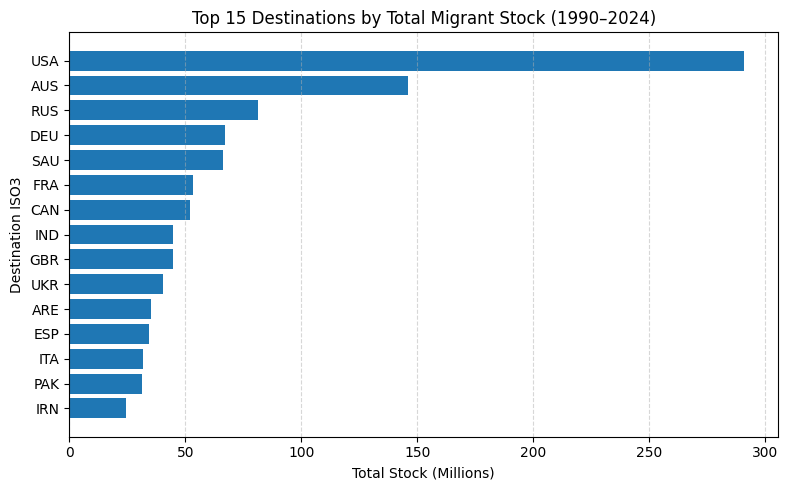

Top 20 countries by total immigrant stock (That is present in both dataset):


,iso3_dest,value,value_million
95,USA,291039170.0,291.039170
7,AUS,146028099.0,146.028099
79,RUS,81245999.0,81.245999
19,CAN,52246823.0,52.246823
35,GBR,44507507.0,44.507507
93,UKR,40266239.0,40.266239
47,IRN,24235389.0,24.235389
41,HKG,20662898.0,20.662898
67,MYS,18968771.0,18.968771
49,KAZ,16004853.0,16.004853


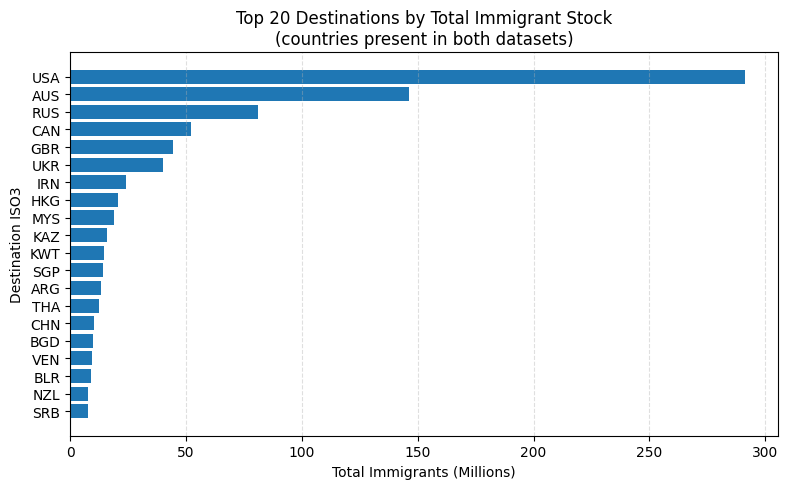


=== Trend Plots ===


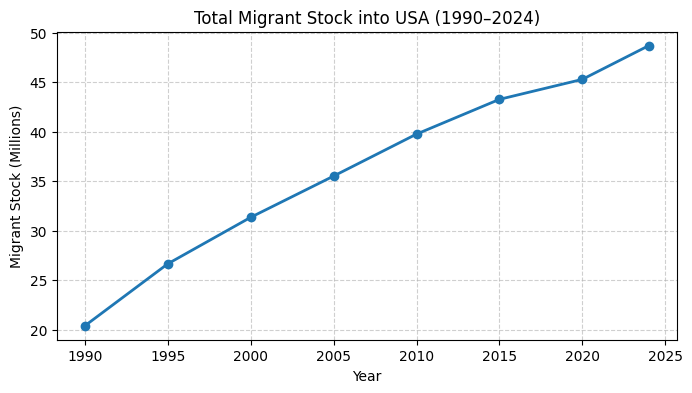

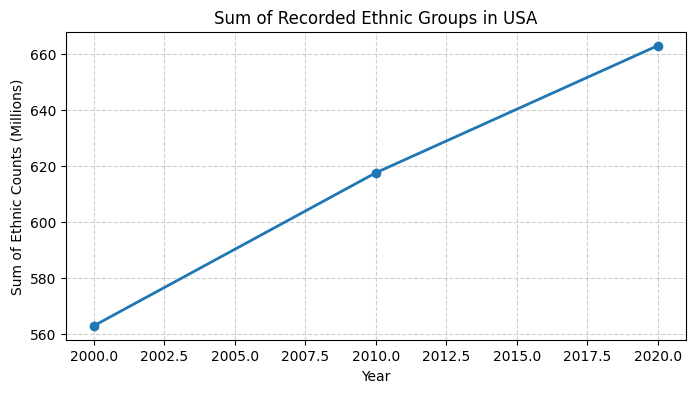

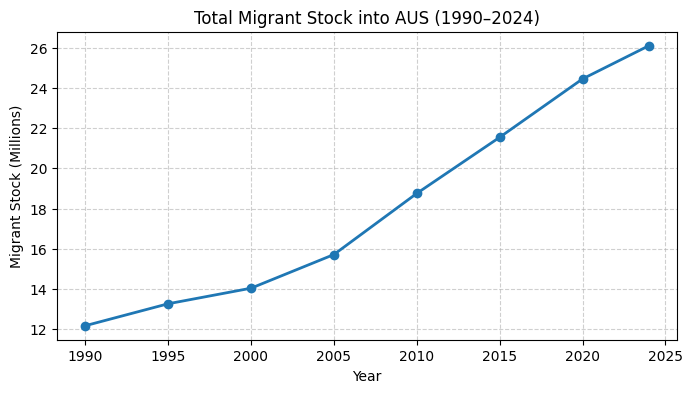

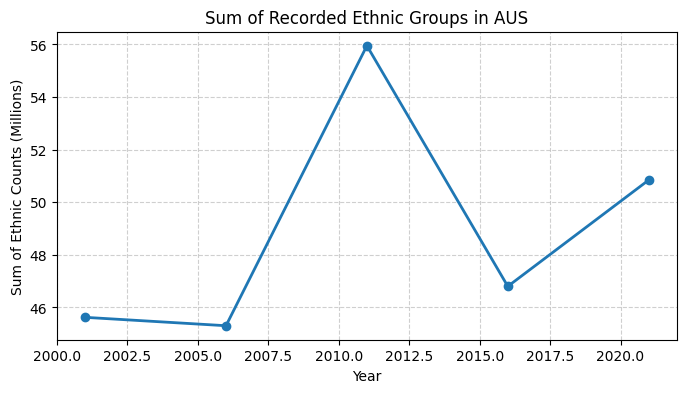

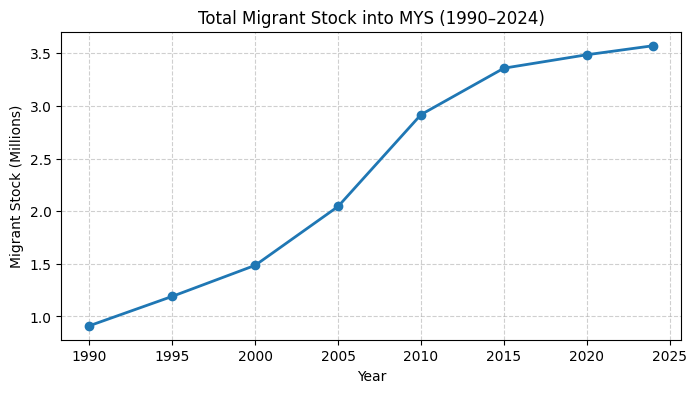

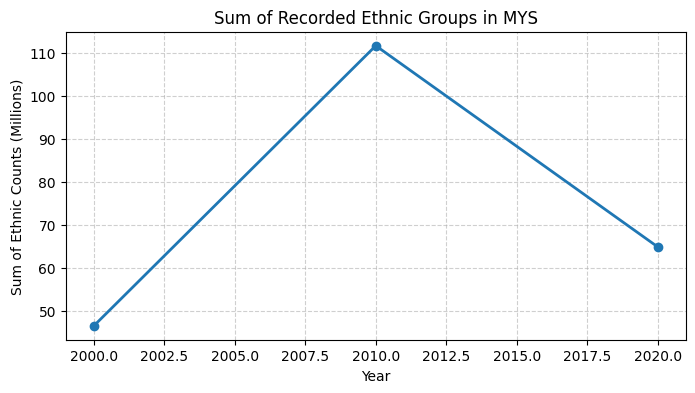


=== Top-Origin ===


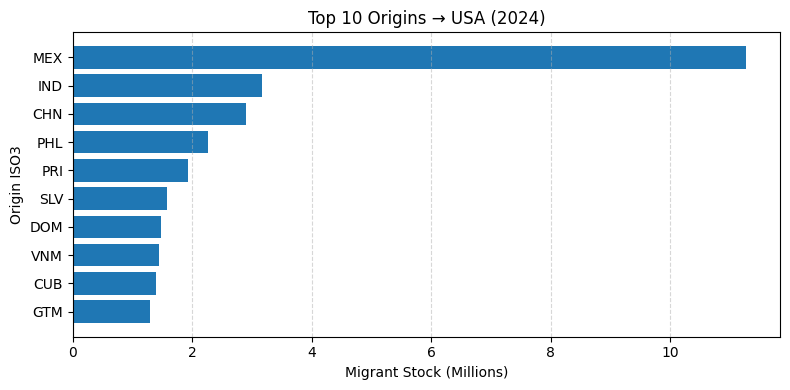

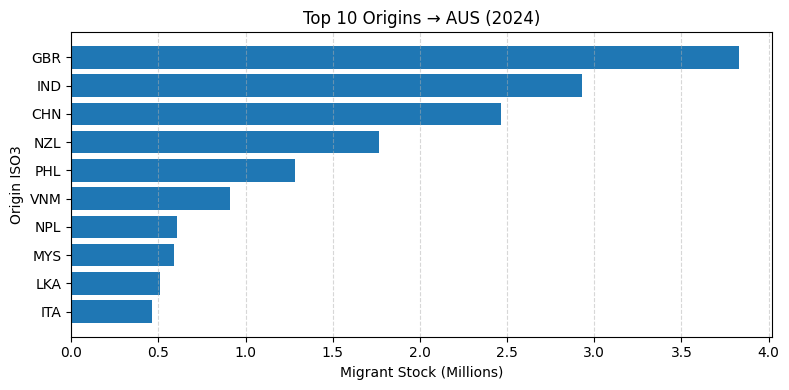

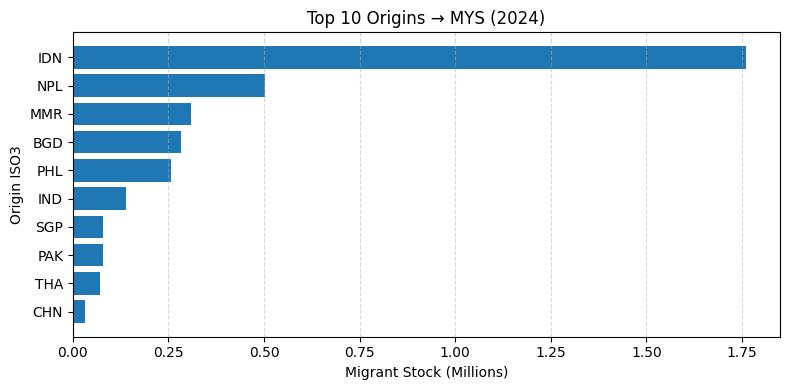

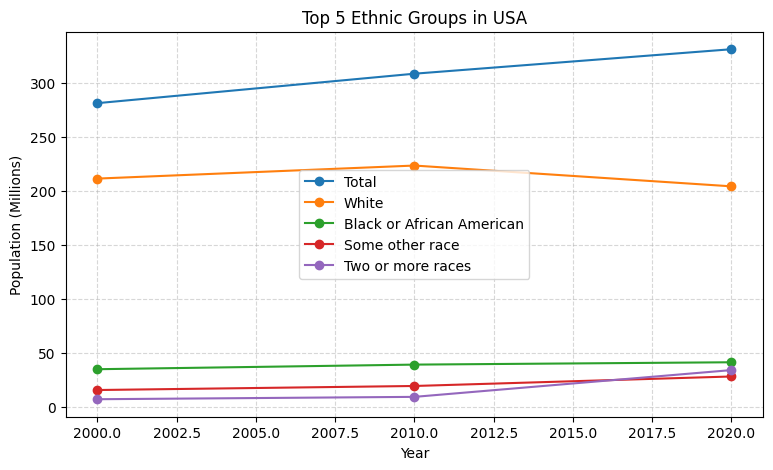

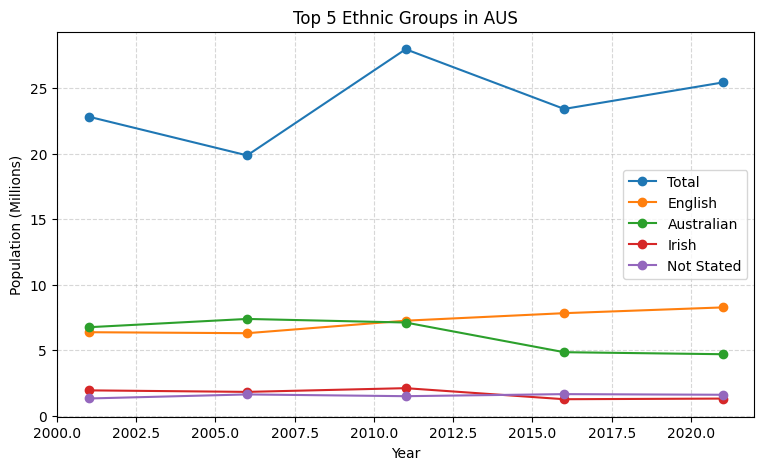

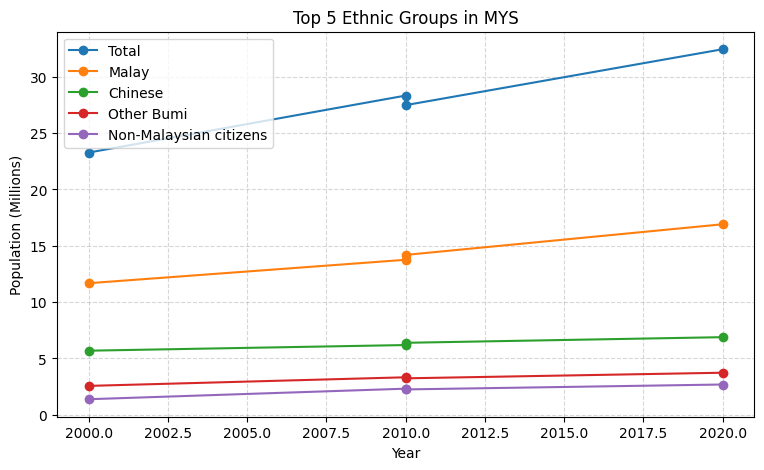

In [77]:
import os
OUT_EDA = f"{BaseDir}/eda_deliverables"
os.makedirs(OUT_EDA, exist_ok=True)

print("=== Coverage Table ===")
# From Goal 5.1
coverage.to_csv(f"{OUT_EDA}/coverage_table.csv", index=False)
display(coverage.head())

# Top countries by total migrant stock
plot_top_destinations_total(ims)

# Top 20 countries by total migrant stock (That is present in both dataset)
ranked_common = rank_countries_by_inflow(ims, common_countries, top_n=20)


print("\n=== Trend Plots ===")
# From Goals 1 & 2 (IMS inflow + Ethnic totals)
for dest in ["USA","AUS","MYS"]:
    plot_total_inflow_trend(ims, dest)
    plot_total_ethnic_sum(ethnic, dest)

print("\n=== Top-Origin ===")
plot_top_origins_2024(ims, "USA")
plot_top_origins_2024(ims, "AUS")
plot_top_origins_2024(ims, "MYS")


plot_major_ethnic_trends(ethnic, "USA", top_n=5)
plot_major_ethnic_trends(ethnic, "AUS", top_n=5)
plot_major_ethnic_trends(ethnic, "MYS", top_n=5)


# print(f"\nAll deliverables saved under: {OUT_EDA}")


In [73]:
coverage

,iso3_dest,ims_years,iso3,ethnic_years
0,ABW,8.0,ABW,2.0
1,AFG,8.0,0,0.0
2,AGO,8.0,0,0.0
3,AIA,8.0,AIA,1.0
5,ALB,8.0,ALB,2.0
...,...,...,...,...
136,0,0.0,MNP,2.0
148,0,0.0,NFK,1.0
170,0,0.0,PYF,1.0
213,0,0.0,VCT,1.0
